# Court Vision Pipeline
### Single Stationary Camera
1. Detect lines or corners of court in a single frame of the clip
2. Compute the homography between the image and the base world frame
3. Make image plane detections. People, Ball etc.
4. Project detections onto base world frame

In [14]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
from courtvision.geometry import (
    get_corners_image,
    get_coords_world_3d_n,
    corners_world_n,
    convert_corners_to_vec,
    PadelCourt,
    compute_homography,
    project_points_to_base_plane
)
from courtvision.geometry import corners_world_3d
import numpy as np
from courtvision.vis import plot_n_images_in_a_grid, load_timg, plot_3d_lines, plot_3d_points
from courtvision.swiss import save_camera_params
import cv2
import torch
import matplotlib.pyplot as plt

import rerun as rr

rr.init("my_app", spawn = True) # Spawn a Rerun Viewer and stream log events to it



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
annotated_frame = Path(
    "/Users/benjamindecharmoy/projects/courtvision/data/frames/curated_001/frame_0001.png"
)
src_corners_n = get_corners_image(annotated_frame)
dst_corners_n = corners_world_n.copy()

named_points_not_labelled_in_image = set(dst_corners_n.keys()) - set(
    src_corners_n.keys()
)
for key in named_points_not_labelled_in_image:
    print(f"Removing {key=}")
    dst_corners_n.pop(key)

Removing key='l_net_line_right'
Removing key='j_net_line_left'
Removing key='k_center_line_near'
Removing key='i_center_line_far'


In [16]:
H, _, _ = compute_homography(
    annotated_frame=annotated_frame,
    src_corners_n=src_corners_n,
    dst_corners_n=dst_corners_n,
)
save_camera_params(
    file_name=annotated_frame,
    homography=H,
)

In [17]:
H

array([[     4.1324,      2.4401,     -2161.7],
       [  -0.044019,      20.011,     -4304.1],
       [-5.9835e-06,   0.0048795,           1]])

In [18]:
frames = sorted(annotated_frame.parent.glob("*.png"))

In [41]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

model.classes = [0]
model.conf = 0.6
model.max_det = 4
results = model.track(
    source="/Users/benjamindecharmoy/projects/courtvision/data/raw/curated_001.mp4",
    # tracker="/Users/benjamindecharmoy/projects/courtvision/bytetrack.yaml",
    tracker="/Users/benjamindecharmoy/projects/courtvision/botsort.yml",
    classes=[0],
    max_det=4,
    save=True,
)



    WARNING ⚠️ stream/video/webcam/dir predict source will accumulate results in RAM unless `stream=True` is passed,
    causing potential out-of-memory errors for large sources or long-running streams/videos.

    Usage:
        results = model(source=..., stream=True)  # generator of Results objects
        for r in results:
            boxes = r.boxes  # Boxes object for bbox outputs
            masks = r.masks  # Masks object for segment masks outputs
            probs = r.probs  # Class probabilities for classification outputs

video 1/1 (1/350) /Users/benjamindecharmoy/projects/courtvision/data/raw/curated_001.mp4: 384x640 4 persons, 37.8ms
video 1/1 (2/350) /Users/benjamindecharmoy/projects/courtvision/data/raw/curated_001.mp4: 384x640 4 persons, 33.1ms
video 1/1 (3/350) /Users/benjamindecharmoy/projects/courtvision/data/raw/curated_001.mp4: 384x640 4 persons, 33.6ms
video 1/1 (4/350) /Users/benjamindecharmoy/projects/courtvision/data/raw/curated_001.mp4: 384x640 4 persons, 33

In [77]:
from collections import defaultdict

base_results = defaultdict(list)
from datetime import datetime

rr.init(
    f"Curated_001-{datetime.now()}", spawn=True
)  # Spawn a Rerun Viewer and stream log events to it

colours_per_idx = defaultdict(lambda: (255, 255, 255))
colours_per_idx.update(
    {
        0: (0, 255, 0),
        1: (0, 0, 255),
        2: (255, 0, 0),
        3: (255, 255, 0),
        4: (255, 0, 255),
        5: (0, 255, 255),
    }
)
court_layout = cv2.imread(
    "/Users/benjamindecharmoy/projects/courtvision/notebooks/test.png"
)
court_layout = cv2.resize(court_layout, (int(PadelCourt.width), int(PadelCourt.length)))
rr.log_image("court_layout", court_layout)
for i, (frame, result) in enumerate(zip(frames, results)):

    rr.set_time_sequence("play", i)
    rr.log_image("rgb_image", result.orig_img)
    court_plane = cv2.warpPerspective(
        result.orig_img,
        H,
        dsize=(int(PadelCourt.width), int(PadelCourt.length)),
    )
    rr.log_image("court_plane", court_plane)

    # rr.log_points("points", positions)
    for det in result.boxes.data:
        x1, y1, x2, y2, idx, conf, cls = det
        rr.log_rect(
            f"rgb_image/Player_{int(idx)}",
            (x1, y1, (x2 - x1), (y2 - y1)),
            color=colours_per_idx[int(idx)],
        )
        # project
        # cv2.rectangle(image, (int(x1), int(y2)), (int(x2), int(y2)), colours_per_idx[int(idx)], 3)
        mid_feet = torch.tensor([((x1 + x2) / 2, (y2 + y2) / 2)])
        (mid_feet_base,) = project_points_to_base_plane(points=mid_feet, H=H)
        rr.log_point(
            f"court_layout/Player_{int(idx)}",
            mid_feet_base,
            radius=50,
            color=colours_per_idx[int(idx)],
        )

        base_results[f"{int(idx)}_xs"].append(mid_feet_base[0].item())
        base_results[f"{int(idx)}_ys"].append(mid_feet_base[1].item())
        base_results[f"{int(idx)}_zs"].append(0.0)
        base_results[f"{int(idx)}_conf"].append(conf.item())

    # if i > 10:
    #     break

    # break
# plt.imshow(image)
# results[0].boxes.boxes, results[0].boxes.data

In [45]:
results[0].orig_img

array([[[ 40,   6,   0],
        [ 40,   6,   0],
        [ 40,   6,   0],
        ...,
        [  0,   6,  23],
        [  0,   6,  23],
        [  0,   6,  23]],

       [[ 40,   6,   0],
        [ 40,   6,   0],
        [ 40,   6,   0],
        ...,
        [  0,   8,  24],
        [  0,   8,  24],
        [  0,   8,  24]],

       [[ 40,   6,   0],
        [ 40,   6,   0],
        [ 40,   6,   0],
        ...,
        [  1,   9,  25],
        [  1,   9,  25],
        [  1,   9,  25]],

       ...,

       [[105,  81,  53],
        [105,  81,  53],
        [105,  81,  53],
        ...,
        [109,  82,  54],
        [107,  80,  52],
        [105,  79,  51]],

       [[105,  81,  53],
        [105,  81,  53],
        [105,  81,  53],
        ...,
        [109,  82,  54],
        [107,  80,  52],
        [105,  79,  51]],

       [[105,  81,  53],
        [105,  81,  53],
        [105,  81,  53],
        ...,
        [109,  82,  54],
        [107,  80,  52],
        [105,  79,  51]]

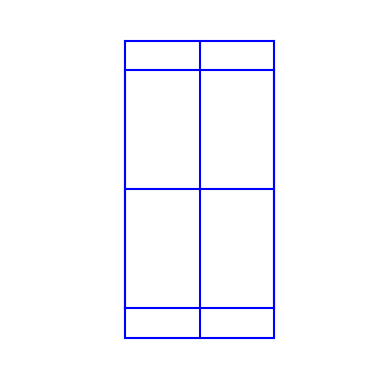

In [65]:
def get_court_markings():
    outer_lines = np.array(
        [
            # Outer lines
            corners_world_3d["a_front_left"],
            corners_world_3d["b_front_right"],
            corners_world_3d["d_back_right"],
            corners_world_3d["c_back_left"],
            corners_world_3d["a_front_left"],
        ],
        dtype=np.float32,
    )
    inner_lines = np.array(
        [
            corners_world_3d["e_left_near_serve_line"],
            corners_world_3d["f_right_near_serve_line"],
            corners_world_3d["h_right_far_serve_line"],
            corners_world_3d["g_left_far_serve_line"],
            corners_world_3d["e_left_near_serve_line"],
        ],
        dtype=np.float32,
    )

    center_line = np.array(
        [
            corners_world_3d["k_center_line_near"],
            corners_world_3d["i_center_line_far"],
        ]
    )
    net_line = np.array(
        [
            corners_world_3d["j_net_line_left"],
            corners_world_3d["l_net_line_right"],
        ]
    )

    xs = np.array([outer_lines[:-1, 0], outer_lines[1:, 0]]).T
    xs = np.append(xs, np.array([inner_lines[:-1, 0], inner_lines[1:, 0]]).T, axis=0)
    xs = np.append(xs, np.array([center_line[:-1, 0], center_line[1:, 0]]).T, axis=0)
    xs = np.append(xs, np.array([net_line[:-1, 0], net_line[1:, 0]]).T, axis=0)

    ys = np.array([outer_lines[:-1, 1], outer_lines[1:, 1]]).T
    ys = np.append(ys, np.array([inner_lines[:-1, 1], inner_lines[1:, 1]]).T, axis=0)
    ys = np.append(ys, np.array([center_line[:-1, 1], center_line[1:, 1]]).T, axis=0)
    ys = np.append(ys, np.array([net_line[:-1, 1], net_line[1:, 1]]).T, axis=0)

    zs = np.array([outer_lines[:-1, 2], outer_lines[1:, 2]]).T
    zs = np.append(zs, np.array([inner_lines[:-1, 2], inner_lines[1:, 2]]).T, axis=0)
    zs = np.append(zs, np.array([center_line[:-1, 2], center_line[1:, 2]]).T, axis=0)
    zs = np.append(zs, np.array([net_line[:-1, 2], net_line[1:, 2]]).T, axis=0)

    return xs, ys, zs


xs, ys, zs = get_court_markings()
plt_axis, fig = plot_3d_lines(xs=xs, ys=ys, zs=zs, view_init=(90, 90, 0))
from courtvision.vis import plot_3d_points

idx = 1
xs = np.array(base_results[f"{idx}_xs"])
ys = np.array(base_results[f"{idx}_ys"])
zs = np.array(base_results[f"{idx}_zs"])
plt_axis.set_title("")
plt_axis.set_xlabel("")
plt_axis.set_ylabel("")
plt_axis.set_xticks([])
plt_axis.set_yticks([])
plt_axis.set_zticks([])
plt_axis.spines["right"].set_visible(False)
plt_axis.spines["top"].set_visible(False)
plt_axis.spines["bottom"].set_visible(False)
plt_axis.spines["left"].set_visible(False)
plt.axis("off")
plt.axis("image")
plt.savefig("test.png", bbox_inches=0)

# plt_axis, _=plot_3d_points(x=xs, y=ys, z=zs, plt_axis=plt_axis ,view_init=(90, 90,0))

/var/folders/nv/c7kqzw0j08q0bg0fjbmbbr4w0000gn/T/ipykernel_42895/857977412.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [5]:
rr.log("test", "test")

TypeError: 'module' object is not callable

<Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>

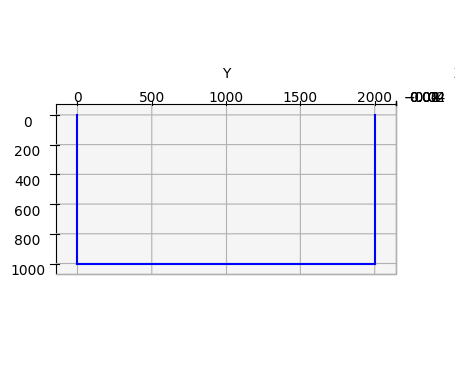

In [78]:
from courtvision.vis import plot_3d_points, plot_3d_lines
from courtvision.geometry import get_coords_world_3d
import numpy as np

court_markings = get_coords_world_3d()
xs = np.array([court_markings[:1, 0], court_markings[1:2, 0]]).T
xs = np.append(xs, np.array([court_markings[1:2, 0], court_markings[3:4, 0]]).T, axis=0)
xs = np.append(xs, np.array([court_markings[3:4, 0], court_markings[4:5, 0]]).T, axis=0)
xs = np.append(xs, np.array([court_markings[4:5, 0], court_markings[:1, 0]]).T, axis=0)

ys = np.array([court_markings[:-1, 1], court_markings[1:, 1]]).T
zs = np.array([court_markings[:-1, 2], court_markings[1:, 2]]).T
plot_3d_lines(xs=xs, ys=ys, zs=zs)
# get_coords_world_3d()